## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
%matplotlib inline

## Create DataFrames

In [4]:
#Categories list to DF
categories = pd.read_csv('./Anno/list_category_cloth.txt', sep='\s{2,}', header=0, skiprows=[0], engine='python')
categories['category_label'] = np.arange(1, len(categories)+1)

#Image DF with partition labels (train/val/test)
#Image DF with category number labels
img_partitions = pd.read_csv('./Eval/list_eval_partition.txt', delim_whitespace=True, header=1)
img_categories = pd.read_csv('./Anno/list_category_img.txt', delim_whitespace=True, header=0, skiprows=[0])

#Merge category img DF with category label DF 
#Merge image DFs for total DF with category and partition labels
img_categories = pd.merge(img_categories, categories, how='left', on='category_label' )
total_df = pd.merge(img_categories, img_partitions, how='left', on='image_name')

## EDA and Cleaning Data

In [5]:
#Combining "Caftan" and "Kaftan" (two different spellings) into one category
for i in total_df[(total_df['category_name'] == 'Caftan')].index:
    total_df.loc[i,'category_label'] = '43'
    total_df.loc[i,'category_name'] = 'Kaftan'
    

In [6]:
drop_categories = total_df['category_name'].value_counts().tail(12).index.tolist()

In [42]:
cleaned_df = total_df.drop(total_df[total_df['category_name'].isin(drop_categories)].index).copy()

In [36]:
def drop_list(category, drop_num):
    cat_index = total_df[(total_df['category_name']== category)&(total_df['evaluation_status'].isin(['train','val']))].index.tolist()
    drop_cat = np.random.choice(cat_index, drop_num, replace=False)
    return drop_cat.tolist()

In [45]:
drop_dress = drop_list('Dress', 52000)
drop_tee = drop_list('Tee', 21000)
drop_blouse = drop_list('Blouse', 11000)
drop_shorts = drop_list('Shorts', 6000)
drop_tank = drop_list('Tank', 3000)
drop_skirt = drop_list('Skirt', 2000)

drop_all_cat = drop_dress + drop_tee + drop_blouse + drop_shorts + drop_tank + drop_skirt

In [46]:
training_df = cleaned_df[cleaned_df['evaluation_status'].isin(['train','val'])][['image_name','category_name']].copy()
training_df.drop(drop_all_cat, inplace=True)

In [47]:
training_df['category_name'].value_counts()

Cardigan       11434
Sweater        11339
Shorts         10895
Skirt          10840
Tee            10796
Tank           10301
Dress          10190
Blouse         10141
Jacket          9021
Top             8667
Blazer          6448
Romper          6414
Jeans           6091
Jumpsuit        5304
Leggings        4289
Joggers         3841
Hoodie          3451
Sweatpants      2640
Kimono          1956
Coat            1816
Cutoffs         1426
Sweatshorts      946
Poncho           685
Jersey           642
Henley           610
Parka            589
Jeggings         530
Chinos           454
Culottes         415
Trunks           345
Button-Down      284
Flannel          273
Bomber           270
Name: category_name, dtype: int64

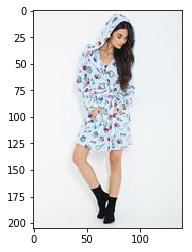

In [61]:
from matplotlib import image

# load the image
data = image.imread('Img/img/Lace-Paneled_Satin_Robe/img_00000012.jpg')

plt.imshow(data)
plt.show()

## Model Training

In [48]:
from fastai import *
from fastai.vision import *

np.random.seed(42)
torch.cuda.set_device(0)

### Loading Data

In [49]:
img_base_path = Path("Img/")
data = ImageDataBunch.from_df(img_base_path, training_df, ds_tfms=get_transforms(), size=150)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (122675 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
Blouse,Blouse,Blouse,Blouse,Blouse
Path: Img;

Valid: LabelList (30668 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
Romper,Tee,Tank,Shorts,Blouse
Path: Img;

Test: None

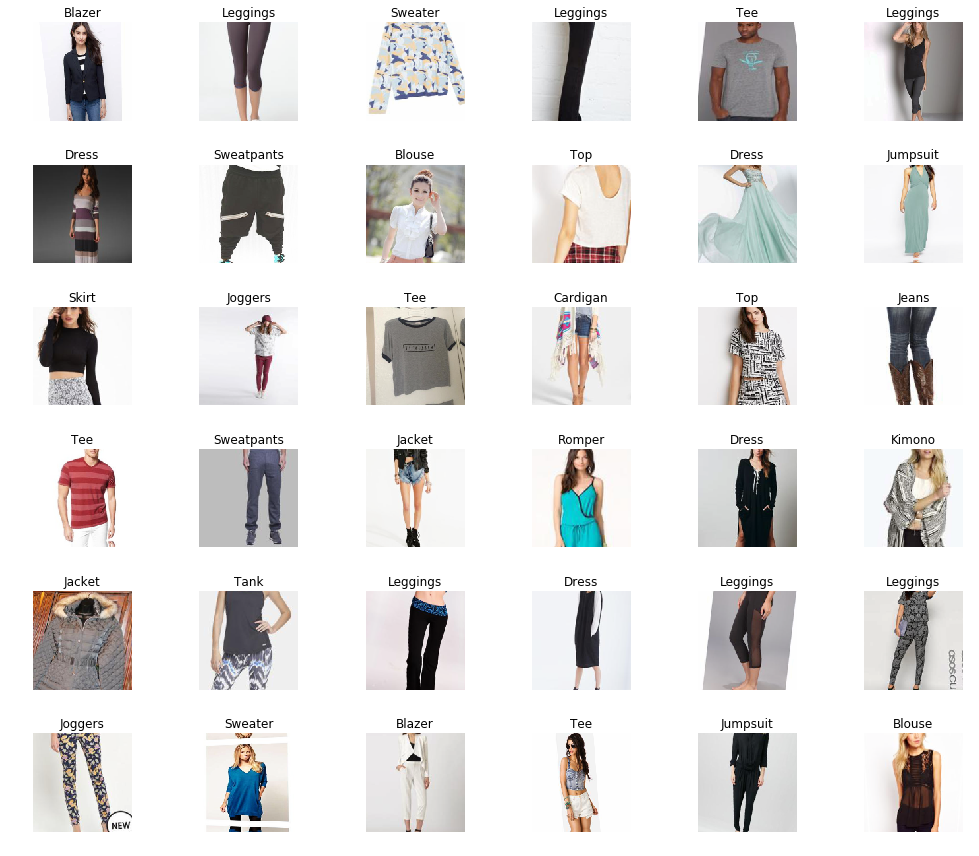

In [50]:
data.show_batch(rows=6, figsize=(14,12))

In [51]:
print(data.classes)
len(data.classes),data.c


['Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Chinos', 'Coat', 'Culottes', 'Cutoffs', 'Dress', 'Flannel', 'Henley', 'Hoodie', 'Jacket', 'Jeans', 'Jeggings', 'Jersey', 'Joggers', 'Jumpsuit', 'Kimono', 'Leggings', 'Parka', 'Poncho', 'Romper', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Sweatshorts', 'Tank', 'Tee', 'Top', 'Trunks']


(33, 33)

In [52]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [53]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.836531,1.722810,0.476490,04:58
1,1.700326,1.558535,0.525695,04:58
2,1.589826,1.489867,0.543629,04:57
3,1.556452,1.471803,0.549987,04:57


In [54]:
learn.save('cat-resnet50-size150-epoch4')

In [55]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


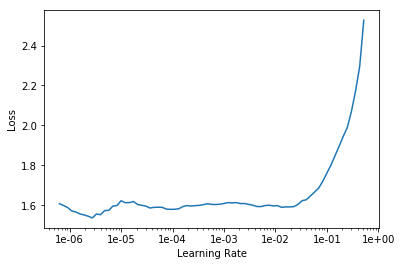

In [56]:
learn.recorder.plot()

In [57]:
learn.unfreeze()

In [58]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.518957,1.423850,0.564954,06:37
1,1.464580,1.398164,0.573953,06:37


In [59]:
learn.export('cat-rn50-size150-fr4-unfr2.pkl')

In [60]:
learn.freeze()

In [61]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.516110,1.428813,0.563910,04:57
1,1.512578,1.411127,0.572975,04:58
2,1.440503,1.382829,0.579366,04:58
3,1.391015,1.380307,0.582529,04:57


In [62]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


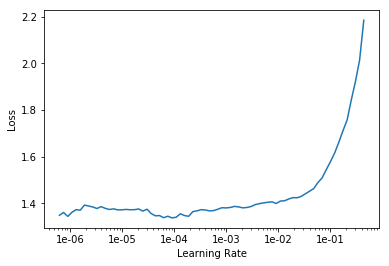

In [63]:
learn.recorder.plot()

In [64]:
learn.unfreeze()

In [65]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.416445,1.366738,0.586898,06:36
1,1.394224,1.337031,0.595768,06:38
2,1.324069,1.323772,0.600007,06:39
3,1.338245,1.320013,0.600659,06:38


In [66]:
learn.export('cat-rn50-size150-fr4-unfr2-fr4-unfr4.pkl')

In [67]:
interp = ClassificationInterpretation.from_learner(learn)

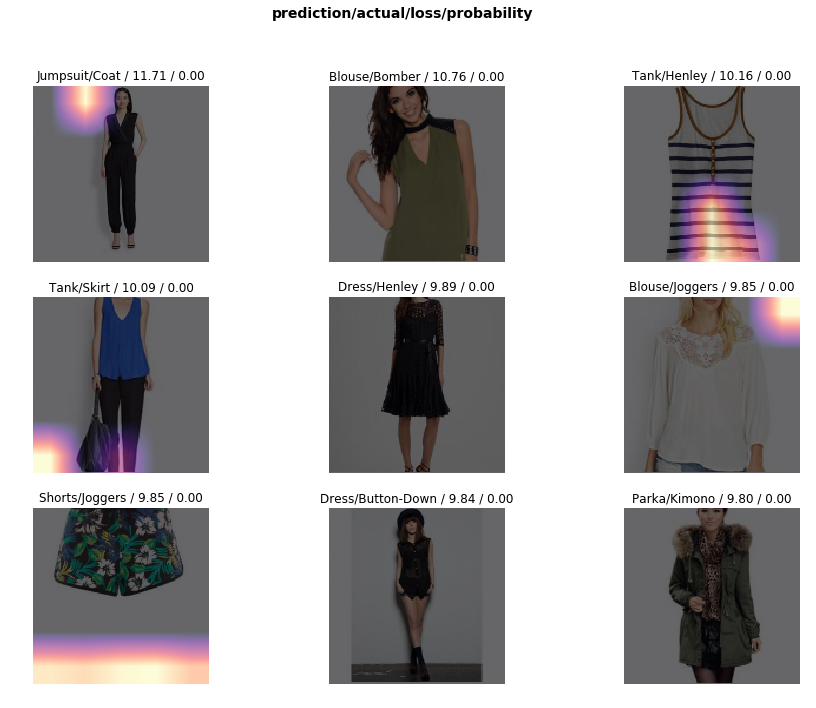

In [68]:
interp.plot_top_losses(9, figsize=(15,11))

In [69]:
interp.most_confused(min_val=80)

[('Top', 'Blouse', 341),
 ('Cardigan', 'Sweater', 340),
 ('Top', 'Tee', 235),
 ('Top', 'Tank', 228),
 ('Tank', 'Tee', 207),
 ('Romper', 'Dress', 203),
 ('Blazer', 'Jacket', 200),
 ('Sweater', 'Cardigan', 200),
 ('Jacket', 'Blazer', 193),
 ('Jumpsuit', 'Dress', 175),
 ('Tee', 'Tank', 175),
 ('Top', 'Sweater', 168),
 ('Cutoffs', 'Shorts', 166),
 ('Shorts', 'Skirt', 141),
 ('Blouse', 'Tank', 139),
 ('Blouse', 'Top', 133),
 ('Jacket', 'Cardigan', 133),
 ('Cardigan', 'Jacket', 129),
 ('Blouse', 'Tee', 127),
 ('Sweatpants', 'Joggers', 121),
 ('Tee', 'Sweater', 121),
 ('Tee', 'Blouse', 115),
 ('Blouse', 'Skirt', 113),
 ('Skirt', 'Dress', 108),
 ('Blazer', 'Cardigan', 107),
 ('Cardigan', 'Blouse', 107),
 ('Joggers', 'Sweatpants', 107),
 ('Top', 'Skirt', 106),
 ('Jumpsuit', 'Romper', 103),
 ('Joggers', 'Jeans', 102),
 ('Dress', 'Romper', 100),
 ('Sweater', 'Tee', 99),
 ('Hoodie', 'Sweater', 98),
 ('Blouse', 'Sweater', 94),
 ('Cardigan', 'Blazer', 93),
 ('Dress', 'Skirt', 89),
 ('Skirt', 'Shorts

In [70]:
def accuracy_topk(output, target, topk=(3,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [71]:
output, target = learn.get_preds(ds_type=DatasetType.Valid)
accuracy_topk(output, target, topk=(3,))

[tensor([83.8594])]

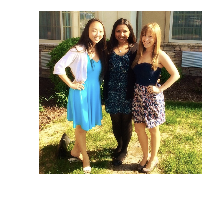

In [27]:
predict_img_path = "/data/Michael/data/predict/2.png"
show_image(open_image(predict_img_path))


In [72]:
category,classIndex,losses = learn.predict(open_image(predict_img_path))
predictions = sorted(zip(data.classes, map(float, losses)), key=lambda p: p[1], reverse=True)
print (predictions[:3])

[('Skirt', 0.6343939900398254), ('Dress', 0.10838621109724045), ('Top', 0.03751622885465622)]
